# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 

Please upload your solved notebook to Moodle (under Milestone 2 Submission)adding your SCIPER number in title, example: m2-lernnavi-456392.ipynb


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.


For the guided part of the exploration we will focus on the three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

### Users
* user_id: unique identifier of user in database.
* gender: only three values: M male, F female or missing (star). 
* canton: swiss canton.
* class_level: school year in swiss system.
* study: boolean variable. True if the student participated in the study.
* class_id: identifier of student’s class (only for the students in the experiment)


### Events
* event_id: unique identifier of event in database.
* user_id: user who peformed the event.
* event_date: timestamp of event.
* category: classification of action (task, general, statistics, etc).
* action: type of action performed.
* event_type: whether the students viewed or clicked in the event.
* transaction_token: used to link to transactions table.
* tracking_data: optional content associated to this event (e.g., the new points mastered for a topic).
* session_id: session during which the event took place.
* topic_id: the topics represent the taxonomy of categories shown in the Deutsch and Math dashboard. See topics_translated table.
* session_closed: whether the session has been finished (1: finished; 0: not finished).
* session_type: whether the session is a learn or level check (1: learn; 2: level check).
* session_accepted: whether the user finally accepted the result of the session (1: accepted; 0: refused).

### Transactions
* transaction_id: unique identifier of transaction in database.
* transaction_token: used to link to events table.
* user_id: user who performed the transaction.
* document_id: document that was answered in transaction.
* document_version: version of document that was answered.
* evaluation: whether the user answered correctly or not. It is possible that it was only partially right. 
* input: answer the user gave.
* start_time: timestamp of when the user started answering.
* commit_time: timestamp of when the user submitted the answer.
* user_agent: the browser that the user used.
* solution: solution to question.
* type: type of question that was answered. 
* session_id: session during which the event took place.
* topic_id: the topics represent the taxonomy of categories shown in the Deutsch and Math dashboard. See topics_translated table.
* session_closed: whether the session has been finished (1: finished; 0: not finished).
* session_type: whether the session is a learn or level check (1: learn; 2: level check).
* session_accepted: whether the user finally accepted the result of the session (1: accepted; 0: refused).
* challenge: (boolean) whether the transaction was part of a challenge or not. Professors can create challenges containing different documents
* challenge_id: unique identifier of challenges. The same challenge can be done by multiple students. The pre-test and post-test in the study were designed like challenges.
* challenge_order: within the challenge, the order of the questions. The order matters because sometimes the questions were adapted depending on the student’s knowledge.
* challenge_name: name given to the challenges. 

## Useful Metadata Files
* [Data description](https://docs.google.com/document/d/1NPFNwi79JddrxZM-CpltH5nHro5btHRSNnYcAGj7Y0A/edit?usp=sharing)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display


In [2]:
# Import the tables of the data set as dataframes.


DATA_DIR = './../../data/Lernnavi' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [3]:
## Your code goes here

print("Number of distinct participants = ",len(users.user_id.unique()))

Number of distinct participants =  30929


#### b) How many transactions were done per user? Please provide a visualization and discuss the distribution.

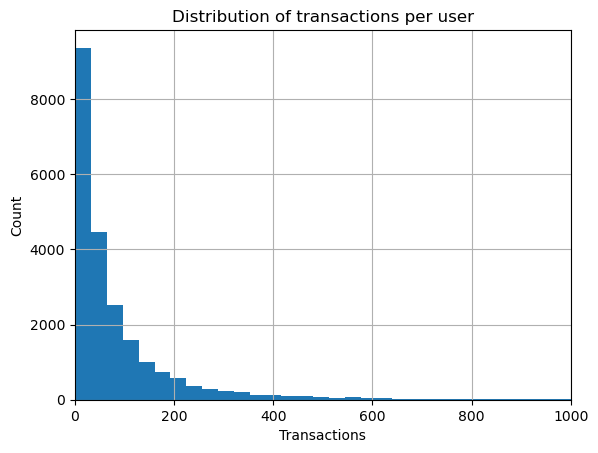

In [4]:
# Your code goes here

transactions_per_user = transactions.groupby("user_id")["transaction_id"].count()
transactions_per_user.hist(bins = 500)

plt.xlim(0,1000)
plt.xlabel("Transactions")
plt.ylabel("Count")
plt.title("Distribution of transactions per user")
plt.show()

Based on the plot of transactions done per user above, it looks like the variable transactions per user follows an exponential distribution.


#### c) Which are the 10 most popular event actions? Please provide a visualization of the frequency of the top 10 event actions.

Hint: See actions in table events.

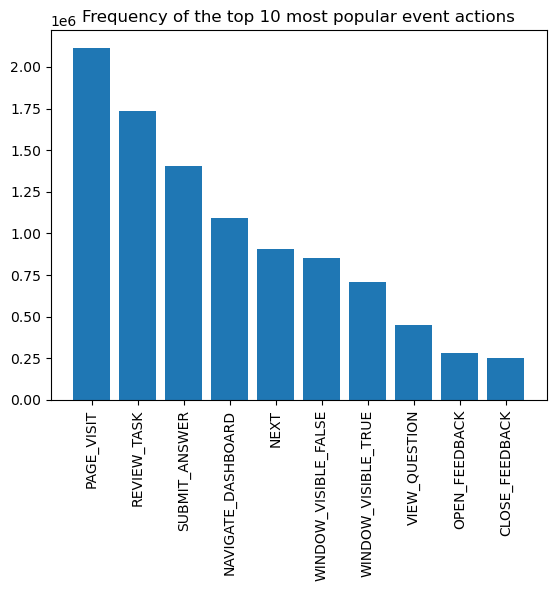

In [5]:
# Your code goes here

top_event_actions = events.groupby(["action"])["event_id"].count().nlargest(10)

plt.bar(top_event_actions.index, top_event_actions.values)
plt.xticks(rotation = 90)
plt.title("Frequency of the top 10 most popular event actions")
plt.show()



PAGE_VISIT: Most popular event action since it is a basic and essential action to perform any sort of activity within the platform. 

REVIEW_TASK : Gets used mutliple times within an excercise suggesting that users either tend to get stuck or are encourage to review their performance before moving onto the next exercise

SUBMIT_ANSWER: Reflects the number of submissiin and attempts made by user, which is a lot. This signfies that the users are completing the exercises

NAV_DASHBOARD: High frequency shows the lateral usage i.e. usage of different elements provided on the platform


## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, gender, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered (hint: action event = submit answer)

- **num_events**: total number of events of the student (hint: in events table)  

- **percentage_correct**: number of correct answers/total number of answers (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers. 

- **num_reading**: total number of theory reading events  (hint: action event = go to theory)

In [6]:
# Your code for building the data frame here
def count_col1(series):
    return (series == "SUBMIT_ANSWER").sum()
def count_col2(series):
    return (series == "GO_TO_THEORY").sum()

num_questions = events.groupby("user_id")["action"].apply(count_col1).reset_index(name='num_question').set_index("user_id")
num_events = events.groupby("user_id")["event_type"].count()
num_reading = events.groupby("user_id")["action"].apply(count_col2).reset_index(name='num_reading').set_index("user_id")

dict = {"WRONG": 0, "PARTIAL": 0.5, "CORRECT": 1, np.NaN:np.NAN}

transactions["score"] = transactions["evaluation"].apply(lambda x: dict[x])

percentage_correct = transactions.groupby("user_id")["score"].mean()*100

In [7]:
# pd.merge(users, df2, left_index=True, right_index=True)
df = pd.DataFrame()

df["num_questions"] = num_questions["num_question"]

df["num_events"] = num_events

df["percentage_correct"] = percentage_correct

df["num_reading"] = num_reading["num_reading"]

df["gender"] = users.set_index("user_id")["gender"]

df["user_id"] = df.index

display(df)

,num_questions,num_events,percentage_correct,num_reading,gender,user_id
user_id,,,,,,
387604,361,5087,69.444444,677,NaN,387604
387605,239,3604,57.352941,35,NaN,387605
387608,117,2359,85.087719,58,NaN,387608
387613,4,213,100.000000,7,NaN,387613
387615,15,535,82.142857,18,MALE,387615
...,...,...,...,...,...,...
431999,4,125,62.500000,0,MALE,431999
432001,6,60,60.000000,0,MALE,432001
432014,9,80,66.666667,1,MALE,432014


b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (gender, num_events, num_questions, percentage_correct, num_reading) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

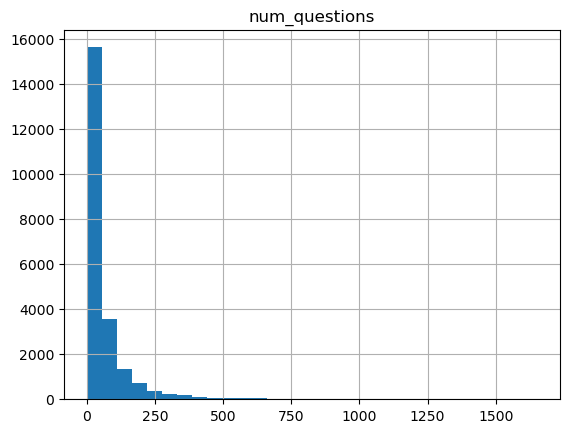

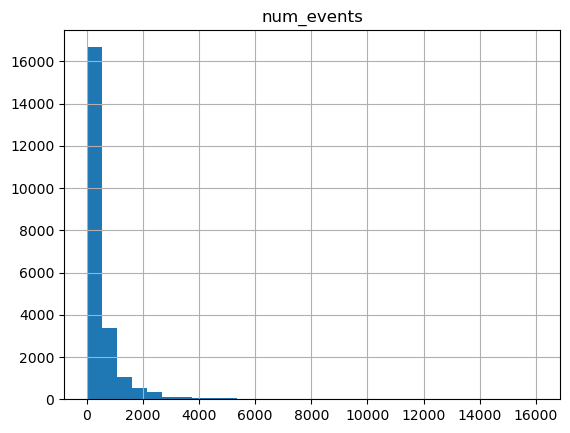

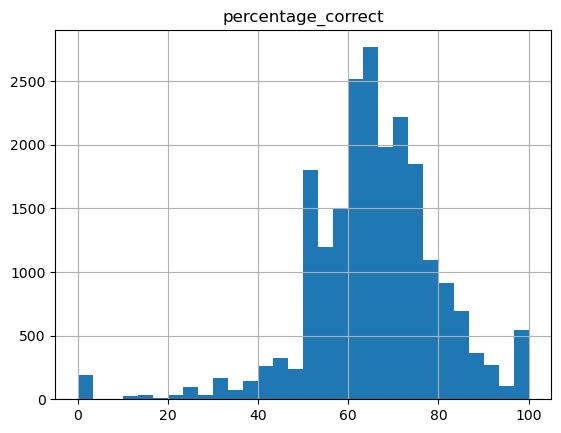

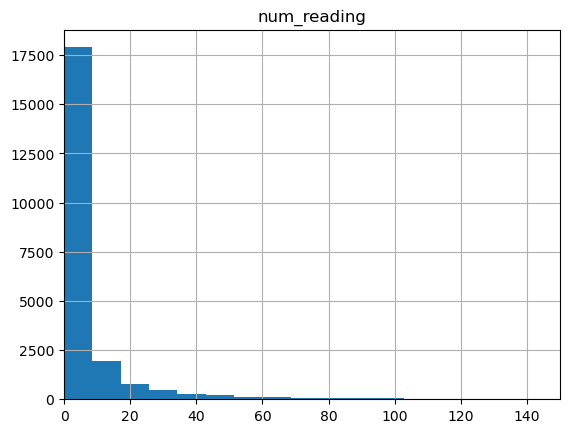

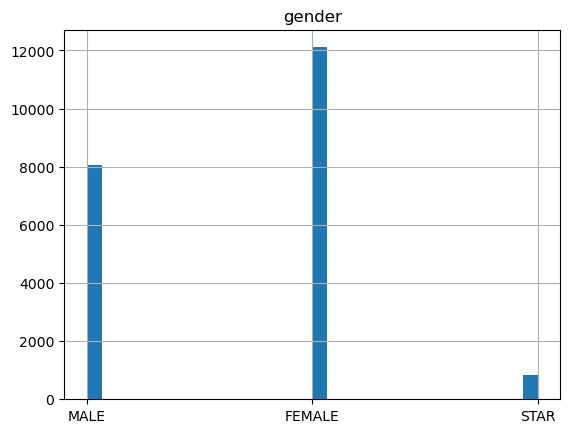

       num_questions    num_events  percentage_correct   num_reading
count   22470.000000  22470.000000        21433.000000  22470.000000
mean       62.489631    498.138451           65.595876      9.408901
std       108.525945    790.250740           14.732039     39.260507
min         0.000000      1.000000            0.000000      0.000000
25%        10.000000    108.000000           58.333333      0.000000
50%        28.000000    249.000000           66.304348      1.000000
75%        68.000000    552.000000           74.324324      6.000000
max      1653.000000  16056.000000          100.000000   3000.000000

 Count for each gender and Nan values
FEMALE    12107
MALE       8072
STAR        820
Name: gender, dtype: int64


In [8]:
# Your code for univariate analysis here

for col in df.columns:
    if col not in ["user_id", "num_reading"]:
        df[col].hist(bins = 30)
        plt.title(col)
        plt.show()

    if col == "num_reading":
        plt.xlim(0,150)
        df[col].hist(bins = 350)
        plt.title(col)
        plt.show()

# code to compute statitics each each feature in the dataframe
print(df.loc[:,df.columns!="user_id"].describe())

# code to give statitsics about gender

print("\n Count for each gender and Nan values")
print(df.gender.value_counts())

1. Num_questions, num_readings and num_events seem to be following the exponential distroibution based on the visualization of these features

2. Percentage correct seems to be highly concentrated around values in the range - 50 to 80. 

3. From the gender distribution we observe that there are 12107 females and 8072 males in the dataset and 820 NaN values.

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

In [9]:
# merge canton column from users dataframe to df based on user id

df2 = pd.merge(df, users.set_index("user_id")[["canton"]], left_index=True, right_index=True)

df2.dropna(inplace=True)

# Feature 1 : caluclate time spent on each question by taking difference between start_time and commit_time in transactions dataframe

transactions["time_spent"] = pd.to_datetime(transactions["commit_time"]) - pd.to_datetime(transactions["start_time"])
transactions["time_spent"] = transactions["time_spent"].apply(lambda x: x.total_seconds()/60.0)
df["avg_time_spent_per_question (min)"] = transactions.groupby("user_id")["time_spent"].mean()


# feature 2
events["Reviewed"] = events["action"].apply(lambda x: 1 if x == "REVIEW_TASK" else 0)
df["num_reviewed"] = events.groupby("user_id")["Reviewed"].sum()


Two additional features that can be very important to study user behaviors are -

Feature 1 - average time spent on a question and compare it with the percentage of correct answers

Feature 2 - number of times user reviews task and compares it to percentage of correct answers and number of questions answered

Hypothesis - 

1. There is minimum amount of time spent on a question in order to have good accuracy in solving the question
2. Number of times the user reviews the questions helps them understand the solution and not repeat similar mistakes

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

,num_reviewed,avg_time_spent_per_question (min)
count,22470.000000,21574.000000
mean,77.197686,615.677277
std,128.282499,7091.111484
min,0.000000,0.017889
25%,13.000000,0.958007
50%,36.000000,1.809752
75%,86.000000,21.369162
max,2487.000000,462673.885367


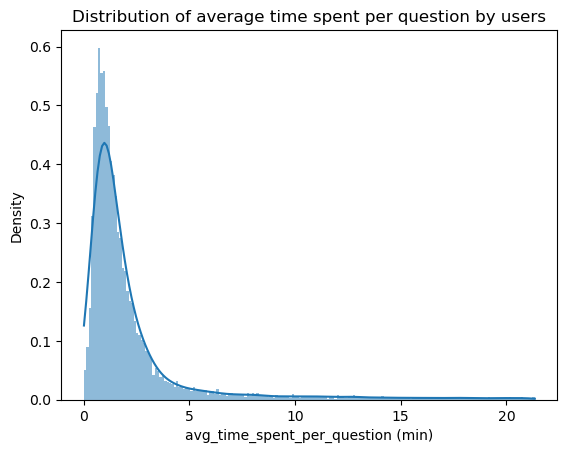

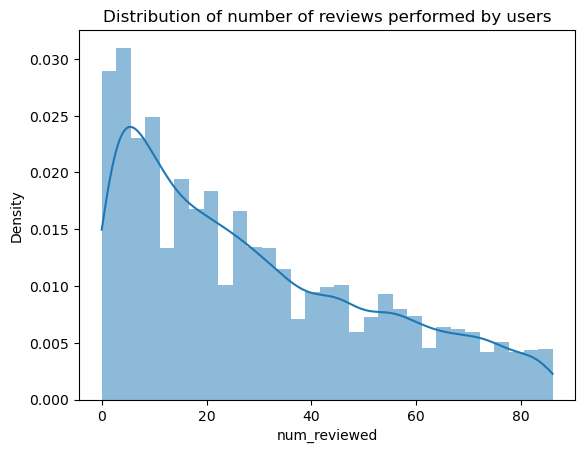

In [10]:
# Your code for univariate analysis for featues num_reviewed and avg_time_spent_per_question here

display(df[["num_reviewed","avg_time_spent_per_question (min)"]].describe())

# Choosing desired percentile as 75 to remove outliers and focus on common user behaviour
percentile = 75

# calculate the value at the desired percentile
threshold_time = df["avg_time_spent_per_question (min)"].quantile(percentile / 100)
threshold_reviewed = df["num_reviewed"].quantile(percentile / 100)

# filter the dataframe to include only rows where avg_time_spent_per_question >= threshold
filtered_df1 = df[df["avg_time_spent_per_question (min)"] <= threshold_time]
filtered_df2 = df[df["num_reviewed"] <= threshold_reviewed]

# create the scatter plot with histograms
# sns.jointplot(x="avg_time_spent_per_question (min)", y="percentage_correct", data=df, kind="scatter")

# sns.distplot(filtered_df1["avg_time_spent_per_question (min)"])
# plt.show()
sns.histplot(filtered_df1["avg_time_spent_per_question (min)"], label="Average time spent per question", kde=True, stat="density", linewidth=0)
plt.title("Distribution of average time spent per question by users")
plt.show()


sns.histplot(filtered_df2["num_reviewed"], label="Number of reviews", kde=True, stat="density", linewidth=0)
plt.title("Distribution of number of reviews performed by users")
plt.show()


1. Average time spend -  Quite a lot of outliers which had to be filtered out for meaningful analysis. On average users mostly spend upto 5 mins on each question

2. Reviews performed by each user - There is actually not a very sharp drop in the distribution for number of reviews 

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

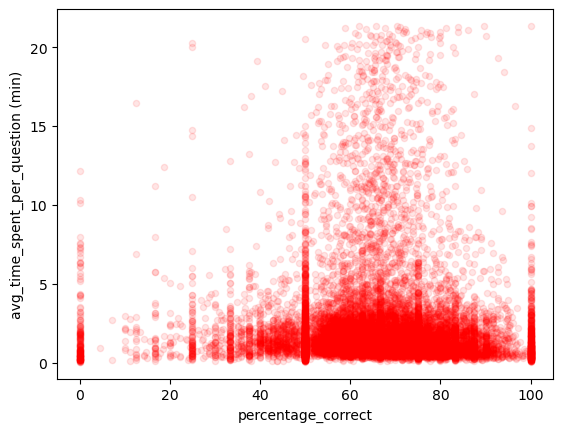

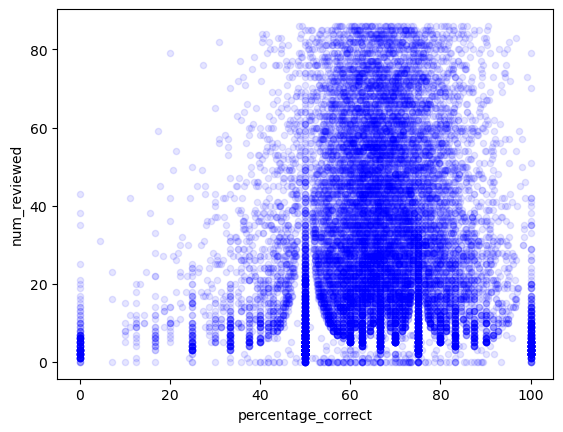

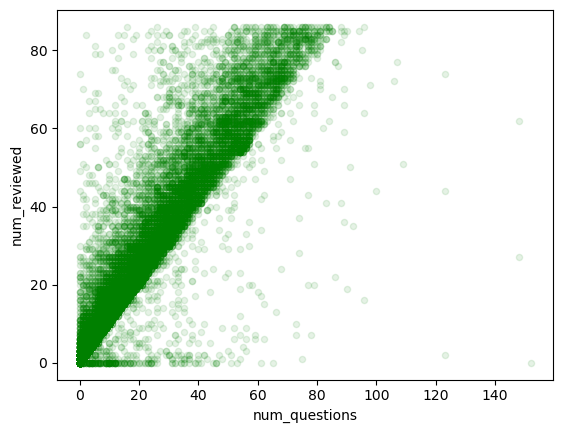

In [11]:
# Your code for multivariate analysis goes here


# create the scatter plot
filtered_df1.plot(kind="scatter", y="avg_time_spent_per_question (min)", x="percentage_correct", alpha=0.1, color="red")

# display the plot
plt.show()

filtered_df2.plot(kind="scatter", y="num_reviewed", x="percentage_correct", alpha=0.1, color="blue")

# display the plot
plt.show()

filtered_df2.plot(kind="scatter", y="num_reviewed", x="num_questions", alpha=0.1, color="green")
plt.show()

1. There is a healthy region that should be spent on a question to have good accuracy in solving problems. Thus confirms the first hypothesis

2. Same goes for the number of reviews peformed by the user, suggesting that reviewing is also essential to increasing solving accuracy

3. From the third graph we see that there is a strong correlation between num_questions and num_reviews

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**(hint: action event = submit answer).

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_reading**: total number of theory reading events **per week** (hint: action event = go to theory).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the transactions table.

Hint: You may extract the week of the year (dt.week) from the timestamps.

Hint 2: Be mindful that week 1 in 2022 is a different week from week 1 in 2023.

You can limit the number of weeks to 10, i.e. for each user we just look at the first 10 weeks of data.
You may change and justify your choice for the number of weeks.

In [12]:
# compute first transaction for each user

transactions['start_time'] = pd.to_datetime(transactions['start_time'])
events['event_date'] = pd.to_datetime(events['event_date'])

first_transaction = transactions.groupby("user_id")["start_time"].min().reset_index(name="first_transaction").set_index("user_id")
first_event = events.groupby("user_id")["event_date"].min().reset_index(name="first_event").set_index("user_id")


transaction_week = transactions.merge(first_transaction["first_transaction"], on="user_id", how="left")
event_week = events.merge(first_event["first_event"], on="user_id", how="left")

transaction_week['week'] = (transaction_week['start_time'] - transaction_week['first_transaction']).dt.days // 7
event_week['week'] = (event_week['event_date'] - event_week['first_event']).dt.days // 7


In [13]:
week_limit = 10

# filter the dataframe to include only rows where week <= week_limit 
transaction_week = transaction_week[transaction_week["week"] <= week_limit]
event_week = event_week[event_week["week"] <= week_limit]


num_questions_week = event_week.groupby(["user_id", "week"])["action"].apply(count_col1).rename('action1')
num_events_week = event_week.groupby(['user_id', 'week'])['event_id'].nunique()
num_reading_week = event_week.groupby(["user_id", "week"])["action"].apply(count_col2)

dict = {"WRONG": 0, "PARTIAL": 0.5, "CORRECT": 1, np.NaN:np.NAN}

transaction_week["score"] = transaction_week["evaluation"].apply(lambda x: dict[x])

percentage_correct_week = (transaction_week.groupby(["user_id", "week"])["score"].mean()*100)

In [14]:
df_week = pd.concat([num_questions_week, num_events_week, percentage_correct_week, num_reading_week], axis=1).reset_index()

df_week = df_week.rename(columns={'action1': 'num_questions','event_id': 'num_events', 'score': 'percentage_correct','action': 'num_reading'})

df_week

,user_id,week,num_questions,num_events,percentage_correct,num_reading
0,387604,0,0.0,2.0,NaN,0.0
1,387604,4,0.0,7.0,NaN,0.0
2,387604,5,0.0,25.0,NaN,0.0
3,387604,10,0.0,12.0,NaN,0.0
4,387605,0,3.0,12.0,83.333333,0.0
...,...,...,...,...,...,...
53852,430426,1,NaN,NaN,NaN,NaN
53853,430844,1,NaN,NaN,60.000000,NaN
53854,431106,1,NaN,NaN,96.511628,NaN
53855,431171,1,NaN,NaN,59.574468,NaN


#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

Selected features -

1.  Num_questions 

2.  Percentage_correct

Discussion : 

1. From the time series visualization of the selected features over the weeks we can observe that the questions solved increase incrementally over short spells of time, with dry spells in between where there is reduced obersved activity in terms of questions submitted.

2. It is also very interesting to observe that percentage_correct follows a similar trend as num_questions suggesting that within the period that the user keeps solving questions, the user does learn to become more accurate. When this activity reduces i.e. lesser num_questions we observe a drop in the user's accuracy. This is very much in line with the understanding that continual testing does lead to better accuracy as it is more regular and constructive. Users might forget the concepts or type of questions they have previously encountered oweing to a reduction in question solving.



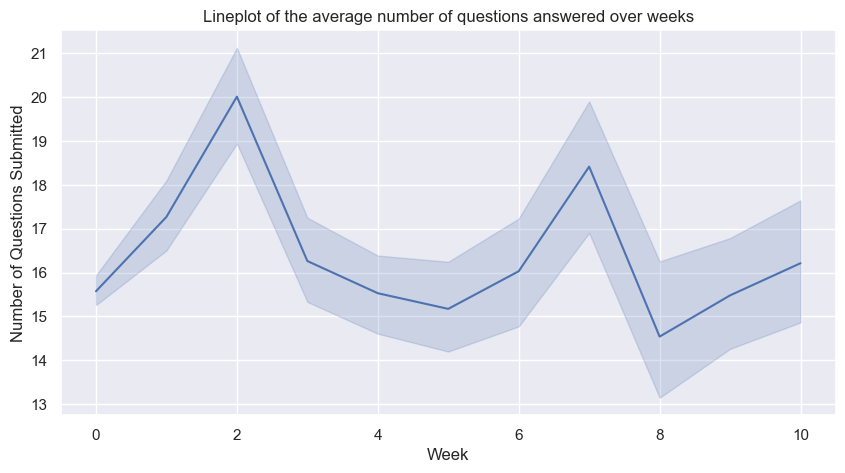

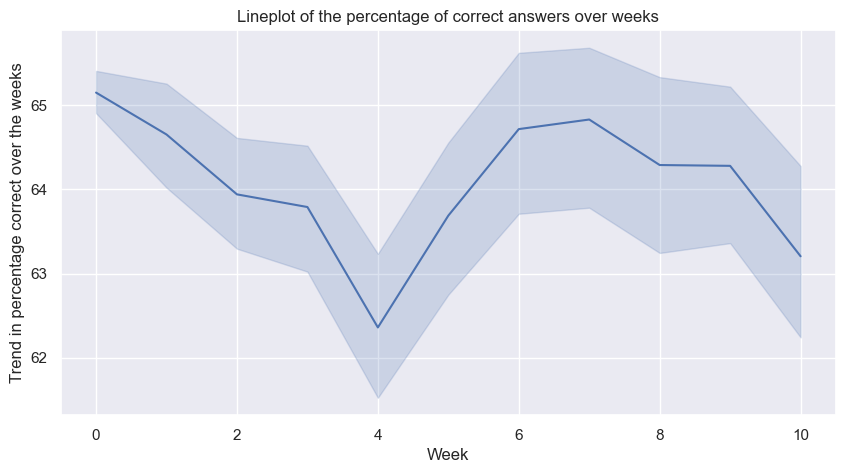

In [15]:
# Since it is a time series, we can plot the trend of the average number of questions answered over weeks using a lineplot


plt.figure(figsize=(10,5))

sns.set_theme(style="darkgrid")

sns.lineplot(x="week", y="num_questions", data=df_week, estimator=np.mean)
plt.title('Lineplot of the average number of questions answered over weeks')
plt.xlabel('Week')
plt.ylabel('Number of Questions Submitted')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x="week", y="percentage_correct", data=df_week.dropna(subset=['percentage_correct']), estimator=np.mean)
plt.title('Lineplot of the percentage of correct answers over weeks')
plt.xlabel('Week')
plt.ylabel('Trend in percentage correct over the weeks')
plt.show()


# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and provide a visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses?



Hypothesis : Different type of questions have different relations with accuracy and number of questions solved. For example in english we might have similar type of questions in CLOZE_TEXT or COZE_TEXT_DROPDOWN whereas Multiple choice questions can be very different thus user does not benifit in increased accuracy due to repition or patterns betwee different questions.

In [16]:
# compute the popular types of questions
types = transactions["type"].value_counts().iloc[:4]

display(types)

MULTIPLE_CHOICE        306214
CLOZE_TEXT_DROPDOWN    263906
CLOZE_TEXT             202705
SOLUTION_FIELD          83532
Name: type, dtype: int64

In [17]:
# compute the percentage of correct answers for each type of question for a user per week using transaction_week dataframe and store it in a dataframe called df_type


df_type = transaction_week[transaction_week["type"].isin(types.index)].groupby(["user_id", "week", "type"]).agg({'score': 'mean', 'type': 'count'}).rename(columns={'score': 'percentage_correct', 'type': 'num_questions'}).reset_index()

df_type



,user_id,week,type,percentage_correct,num_questions
0,387605,0,CLOZE_TEXT,0.750000,2
1,387605,6,CLOZE_TEXT,0.428571,7
2,387605,6,CLOZE_TEXT_DROPDOWN,0.750000,8
3,387605,6,MULTIPLE_CHOICE,0.642857,7
4,387605,6,SOLUTION_FIELD,1.000000,2
...,...,...,...,...,...
77608,432014,0,CLOZE_TEXT_DROPDOWN,1.000000,1
77609,432014,0,MULTIPLE_CHOICE,1.000000,4
77610,432014,0,SOLUTION_FIELD,0.000000,1
77611,432016,0,MULTIPLE_CHOICE,0.666667,3


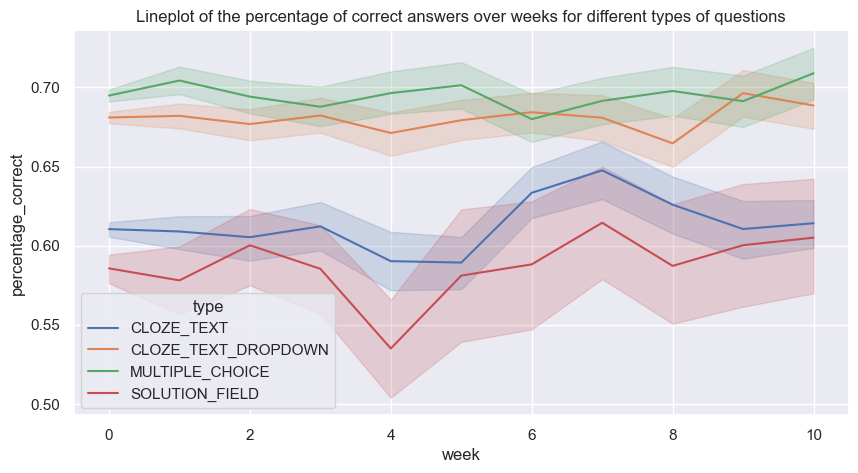

In [18]:
# Plot the responses for different events and regions
plt.figure(figsize=(10,5))
sns.lineplot(x="week", y="percentage_correct",hue="type",data=df_type, estimator=np.mean)
plt.title("Lineplot of the percentage of correct answers over weeks for different types of questions")
plt.show()

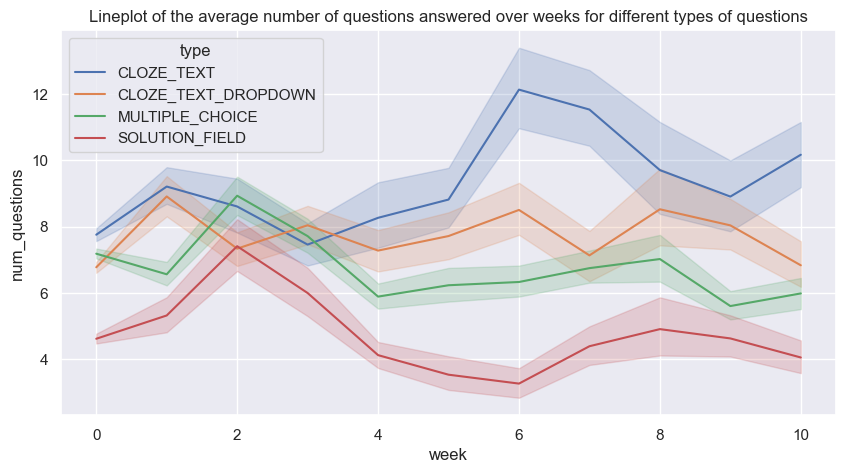

In [19]:
plt.figure(figsize=(10,5))
sns.lineplot(x="week", y="num_questions",hue="type",data=df_type, estimator=np.mean)
plt.title("Lineplot of the average number of questions answered over weeks for different types of questions")
plt.show()

Observation and Discussion

1. SOLUTION_FIELD : Clearly shows a drop in number of questions submitted matches with the week when there was reduced accuracy in solving it.

2. MULTIPLE_CHOICE and CLOZE_TEXT_DROPDOWN : Show a relatively similar accuracy for users solving similar number of questions over time

3. CLOZE_TEXT : We observe from the graphs that as the user solves more and more questions, on average they are able to imporve their accuracy over time

Using this study we can conduct an experiment to test what type of questions encourage the users to solve more questions and alsoe lead to better learning and increased accuracy over time.